In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing
from copy import deepcopy

import jax
import jax.numpy as jnp

import numpyro
import numpyro.infer
# import render
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam, TransformReparam
from numpyro.contrib.control_flow import scan

import arviz as az

In [5]:
from numpyro.handlers import condition, seed, substitute, trace
from jax import random

In [6]:
import itertools
from pathlib import Path

import jax

from numpyro import handlers
import numpyro.distributions as dist


def get_model_relations(model, model_args=None, model_kwargs=None, num_tries=10):
    """
    Infer relations of RVs and plates from given model and optionally data.
    See https://github.com/pyro-ppl/numpyro/issues/949 for more details.
    This returns a dictionary with keys:
    -  "sample_sample" map each downstream sample site to a list of the upstream
       sample sites on which it depend;
    -  "sample_dist" maps each sample site to the name of the distribution at
       that site;
    -  "plate_sample" maps each plate name to a lists of the sample sites
       within that plate; and
    -  "observe" is a list of observed sample sites.
    For example for the model::
        def model(data):
            m = numpyro.sample('m', dist.Normal(0, 1))
            sd = numpyro.sample('sd', dist.LogNormal(m, 1))
            with numpyro.plate('N', len(data)):
                numpyro.sample('obs', dist.Normal(m, sd), obs=data)
    the relation is::
        {'sample_sample': {'m': [], 'sd': ['m'], 'obs': ['m', 'sd']},
         'sample_dist': {'m': 'Normal', 'sd': 'LogNormal', 'obs': 'Normal'},
         'plate_sample': {'N': ['obs']},
         'observed': ['obs']}
    :param callable model: A model to inspect.
    :param model_args: Optional tuple of model args.
    :param model_kwargs: Optional dict of model kwargs.
    :param int num_tries: Optional number times to trace model to detect
        discrete -> continuous dependency.
    :rtype: dict
    """
    model_args = model_args or ()
    model_kwargs = model_kwargs or {}

    trace = handlers.trace(handlers.seed(model, 0)).get_trace(
        *model_args, **model_kwargs
    )
    obs_sites = [
        name
        for name, site in trace.items()
        if site["type"] == "sample" and site["is_observed"]
    ]

    def _get_dist_name(fn):
        if isinstance(
            fn, (dist.Independent, dist.ExpandedDistribution, dist.MaskedDistribution)
        ):
            return _get_dist_name(fn.base_dist)
        return type(fn).__name__

    sample_dist = {
        name: _get_dist_name(site["fn"])
        for name, site in trace.items()
        if site["type"] == "sample"
    }

    sample_plates = {
        name: [frame.name for frame in site["cond_indep_stack"]]
        for name, site in trace.items()
        if site["type"] == "sample"
    }
    plate_samples = {
        k: {name for name, plates in sample_plates.items() if k in plates}
        for k in trace
        if trace[k]["type"] == "plate"
    }

    def _resolve_plate_samples(plate_samples):
        for p, pv in plate_samples.items():
            for q, qv in plate_samples.items():
                if len(pv & qv) > 0 and len(pv - qv) > 0 and len(qv - pv) > 0:
                    plate_samples_ = plate_samples.copy()
                    plate_samples_[q] = pv & qv
                    plate_samples_[q + "__CLONE"] = qv - pv
                    return _resolve_plate_samples(plate_samples_)
        return plate_samples

    plate_samples = _resolve_plate_samples(plate_samples)
    # convert set to list to keep order of variables
    plate_samples = {
        k: [name for name in trace if name in v] for k, v in plate_samples.items()
    }

    def get_log_probs(sample, seed=0):
        with handlers.trace() as tr, handlers.seed(model, seed), handlers.substitute(
            data=sample
        ):
            model(*model_args, **model_kwargs)
        return {
            name: site["fn"].log_prob(site["value"])
            for name, site in tr.items()
            if site["type"] == "sample"
        }

    samples = {
        name: site["value"]
        for name, site in trace.items()
        if site["type"] == "sample"
        and not site["is_observed"]
        and not site["fn"].is_discrete
    }
    log_prob_grads = jax.jacobian(get_log_probs)(samples)
    sample_deps = {}
    for name, grads in log_prob_grads.items():
        sample_deps[name] = {n for n in grads if n != name and (grads[n] != 0).any()}

    # find discrete -> continuous dependency
    samples = {
        name: site["value"] for name, site in trace.items() if site["type"] == "sample"
    }
    discrete_sites = [
        name
        for name, site in trace.items()
        if site["type"] == "sample"
        and not site["is_observed"]
        and site["fn"].is_discrete
    ]
    log_probs_prototype = get_log_probs(samples)
    for name in discrete_sites:
        samples_ = samples.copy()
        samples_.pop(name)
        for i in range(num_tries):
            log_probs = get_log_probs(samples_, seed=i + 1)
            for var in samples:
                if var == name:
                    continue
                if (log_probs[var] != log_probs_prototype[var]).any():
                    sample_deps[var] |= {name}
    sample_sample = {}
    for name in samples:
        sample_sample[name] = [var for var in samples if var in sample_deps[name]]
    return {
        "sample_sample": sample_sample,
        "sample_dist": sample_dist,
        "plate_sample": plate_samples,
        "observed": obs_sites,
    }


def generate_graph_specification(model_relations):
    """
    Convert model relations into data structure which can be readily
    converted into a network.
    """
    # group nodes by plate
    plate_groups = dict(model_relations["plate_sample"])
    plate_rvs = {rv for rvs in plate_groups.values() for rv in rvs}
    plate_groups[None] = [
        rv for rv in model_relations["sample_sample"] if rv not in plate_rvs
    ]  # RVs which are in no plate

    # retain node metadata
    node_data = {}
    for rv in model_relations["sample_sample"]:
        node_data[rv] = {
            "is_observed": rv in model_relations["observed"],
            "distribution": model_relations["sample_dist"][rv],
        }

    # infer plate structure
    # (when the order of plates cannot be determined from subset relations,
    # it follows the order in which plates appear in trace)
    plate_data = {}
    for plate1, plate2 in list(itertools.combinations(plate_groups, 2)):
        if plate1 is None or plate2 is None:
            continue

        if set(plate_groups[plate1]) < set(plate_groups[plate2]):
            plate_data[plate1] = {"parent": plate2}
        elif set(plate_groups[plate1]) >= set(plate_groups[plate2]):
            plate_data[plate2] = {"parent": plate1}

    for plate in plate_groups:
        if plate is None:
            continue

        if plate not in plate_data:
            plate_data[plate] = {"parent": None}

    # infer RV edges
    edge_list = []
    for target, source_list in model_relations["sample_sample"].items():
        edge_list.extend([(source, target) for source in source_list])

    return {
        "plate_groups": plate_groups,
        "plate_data": plate_data,
        "node_data": node_data,
        "edge_list": edge_list,
    }


def render_graph(graph_specification, render_distributions=False):
    """
    Create a graphviz object given a graph specification.
    :param bool render_distributions: Show distribution of each RV in plot.
    """
    try:
        import graphviz  # noqa: F401
    except ImportError as e:
        raise ImportError(
            "Looks like you want to use graphviz (https://graphviz.org/) "
            "to render your model. "
            "You need to install `graphviz` to be able to use this feature. "
            "It can be installed with `pip install graphviz`."
        ) from e

    plate_groups = graph_specification["plate_groups"]
    plate_data = graph_specification["plate_data"]
    node_data = graph_specification["node_data"]
    edge_list = graph_specification["edge_list"]

    graph = graphviz.Digraph()

    # add plates
    plate_graph_dict = {
        plate: graphviz.Digraph(name=f"cluster_{plate}")
        for plate in plate_groups
        if plate is not None
    }
    for plate, plate_graph in plate_graph_dict.items():
        plate_graph.attr(label=plate.split("__CLONE")[0], labeljust="r", labelloc="b")

    plate_graph_dict[None] = graph

    # add nodes
    for plate, rv_list in plate_groups.items():
        cur_graph = plate_graph_dict[plate]

        for rv in rv_list:
            color = "grey" if node_data[rv]["is_observed"] else "white"
            cur_graph.node(
                rv, label=rv, shape="ellipse", style="filled", fillcolor=color
            )

    # add leaf nodes first
    while len(plate_data) >= 1:
        for plate, data in plate_data.items():
            parent_plate = data["parent"]
            is_leaf = True

            for plate2, data2 in plate_data.items():
                if plate == data2["parent"]:
                    is_leaf = False
                    break

            if is_leaf:
                plate_graph_dict[parent_plate].subgraph(plate_graph_dict[plate])
                plate_data.pop(plate)
                break

    # add edges
    for source, target in edge_list:
        graph.edge(source, target)

    # render distributions if requested
    if render_distributions:
        dist_label = ""
        for rv, data in node_data.items():
            rv_dist = data["distribution"]
            dist_label += rf"{rv} ~ {rv_dist}\l"

        graph.node("distribution_description_node", label=dist_label, shape="plaintext")

    # return whole graph
    return graph


def render_model(
    model,
    model_args=None,
    model_kwargs=None,
    filename=None,
    render_distributions=False,
    num_tries=10,
):
    """
    Wrap all functions needed to automatically render a model.
    .. warning:: This utility does not support the
        :func:`~numpyro.contrib.control_flow.scan` primitive yet.
    .. warning:: Currently, this utility uses a heuristic approach,
        which will work for most cases, to detect dependencies in a NumPyro model.
    :param model: Model to render.
    :param model_args: Positional arguments to pass to the model.
    :param model_kwargs: Keyword arguments to pass to the model.
    :param str filename: File to save rendered model in.
    :param bool render_distributions: Whether to include RV distribution annotations in the plot.
    :param int num_tries: Times to trace model to detect discrete -> continuous dependency.
    """
    relations = get_model_relations(
        model, model_args=model_args, model_kwargs=model_kwargs, num_tries=num_tries
    )
    graph_spec = generate_graph_specification(relations)
    graph = render_graph(graph_spec, render_distributions=render_distributions)

    if filename is not None:
        filename = Path(filename)
        graph.render(
            filename.stem, view=False, cleanup=True, format=filename.suffix[1:]
        )  # remove leading period from suffix

    return graph

In [118]:
from dataset import ApAvDataset
j = 0

path_to_data = '/Users/julianstastny/Code/masters-thesis/test_data_for_sebastian'
dataset = ApAvDataset(path_to_data=path_to_data)
data = dataset.get_data()
concatenated_data = pd.concat([pd.concat((data[i]['stim0'], data[i]['stim1'], data[i]['resid'])) for i in range(len(data))])

scaler = preprocessing.StandardScaler().fit(concatenated_data[['reward_amount', 'aversi_amount']])

clf = linear_model.LogisticRegression()
parameters = {}
for i, stage in enumerate(['stim0', 'stim1', 'resid']):
    _X = scaler.transform(data[j][stage][['reward_amount', 'aversi_amount']])
    _y = data[j][stage]['appro1_avoid0']
    clf.fit(_X, _y)
    parameters[stage] = {'coef': clf.coef_, 'intercept': clf.intercept_}
_X = scaler.transform(concatenated_data[['reward_amount', 'aversi_amount']])
_y = concatenated_data['appro1_avoid0']
clf.fit(_X, _y)
parameters['all'] = {'coef': clf.coef_, 'intercept': clf.intercept_}

def get_coefs_for_sklearn(id_str):
    clf_new = deepcopy(clf)
    clf_new.coef_ = parameters[id_str]['coef']
    clf_new.intercept_ = parameters[id_str]['intercept']
    return clf_new

def get_coefs_for_numpyro(id_str):
    coef = parameters[id_str]['coef'].flatten()
    intercept = parameters[id_str]['intercept']
    return np.expand_dims(np.concatenate((coef, intercept), axis=0), 1)

In [119]:
OFFERS = scaler.transform(np.array(concatenated_data[['reward_amount', 'aversi_amount']]))
STIM_INDICATOR = np.concatenate([np.array([0] * len(data[i]['stim0']) + [1] * len(data[i]['stim1']) + [0] * len(data[i]['resid'])) for i in range(len(data))], 0)
STAGE = np.concatenate([np.array([0] * len(data[i]['stim0']) + [1] * len(data[i]['stim1']) + [2] * len(data[i]['resid'])) for i in range(len(data))], 0)

In [109]:
get_coefs_for_numpyro('all')

array([[ 0.95452189],
       [-2.05845389],
       [-1.8750552 ]])

In [9]:
num_stim0_trials = 250
num_stim1_trials = 250
num_resid_trials = 250

In [10]:
def generate_trial_offers(num_trials, scale=True):
    offers = np.random.choice(np.arange(101), size=(num_trials, 2))
    if scale:
        return scaler.transform(offers)
    return offers

In [11]:
def generate_X(num_stim0_trials):
    offers = generate_trial_offers(num_stim0_trials)
    X = np.concatenate([offers] * 3, 0)
    stimulation = np.array([0] * num_stim0_trials + [1] * num_stim0_trials + [2] * num_stim0_trials)
    one_hot = np.eye(3)[stimulation]
    return X, stimulation

In [12]:
def sample_from_model(model_fn, z_condition: dict, z_sample=('y'), num_samples=1, **kwargs):
    samples = {z: [] for z in z_sample}
    model = condition(model_fn, z_condition)
    for _seed in range(num_samples):
        model = seed(model, random.PRNGKey(_seed))
        _trace = trace(model).get_trace(**kwargs)
        for z in z_sample:
            samples[z] += [np.asarray(_trace[z]['value'])]
    return samples

In [152]:
simple_mechanistic_model

<function __main__.generate_simple_mechanistic_model.<locals>.latent_utility_model_nostim(X, y=None)>

In [81]:
X, stimulation = generate_X(250)

In [82]:
offers = generate_trial_offers(600)

In [138]:
samples = sample_from_model(regularized_random_walk_model, {'initial_weight': get_coefs_for_numpyro('all')}, z_sample=['y', 'stimulated_weights'], num_samples=1, X=OFFERS,)
# samples = sample_from_model(model, offers, {'initial_weight': get_coefs_for_numpyro('all')}, z_sample=['y'], num_samples=1)

In [153]:
samples = sample_from_model(simple_mechanistic_model, {'init_weight': get_coefs_for_numpyro('stim0')}, z_sample=['y', 'stimulated_weights'], num_samples=1, X=OFFERS, stage=STAGE)


TypeError: latent_utility_model_nostim() got an unexpected keyword argument 'stage'

In [145]:
idata = az.from_numpyro(mcmc)

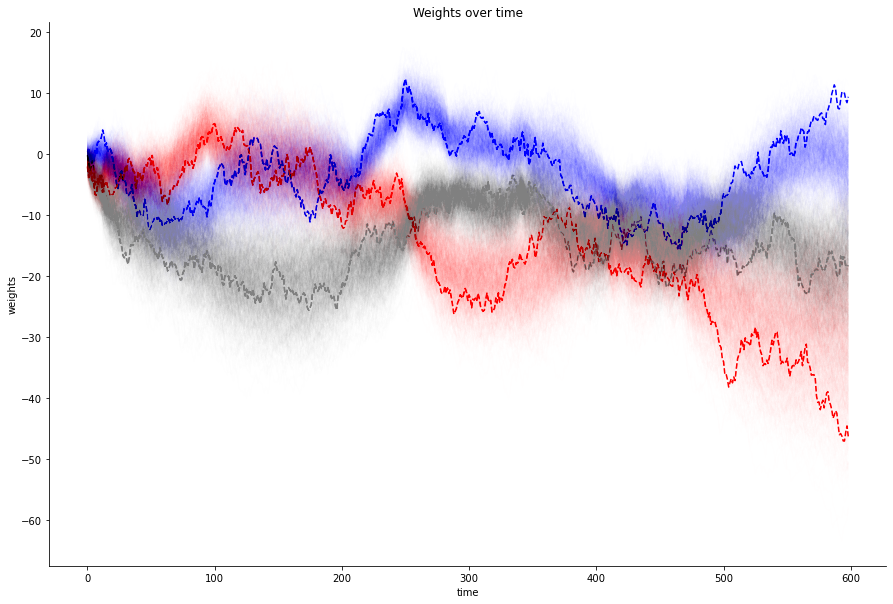

In [146]:
fig = plt.figure(figsize=(15, 10))
plt.plot(samples['stimulated_weights'][0][:,0], alpha=1, color='b', linestyle='--'); # Red = reward weights
plt.plot(samples['stimulated_weights'][0][:,1], alpha=1, color='r', linestyle='--'); # Blue = aversion weights
plt.plot(samples['stimulated_weights'][0][:,2], alpha=1, color='grey', linestyle='--'); # Grey = intercept

plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:, :, 0].T, alpha=.005, color='b'); # Red = reward weights
plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:, :, 1].T, alpha=.005, color='r'); # Blue = aversion weights
plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:, :, 2].T, alpha=.005, color='grey'); # Grey = intercept


plt.xlabel('time'); plt.ylabel('weights'); plt.title('Weights over time'); sns.despine();

In [127]:
def plot_psychometric_function(logits):
    fig = plt.figure(figsize=(10, 5))
    probs = jax.nn.sigmoid(logits)
    lims = np.max(np.abs(logits))
    xrange = np.linspace(-lims, lims, 1000)
    sigma = jax.nn.sigmoid(xrange)
    plt.plot(xrange, sigma, color='black')
    plt.scatter(logits, probs, c=logits>0, cmap='bwr_r')

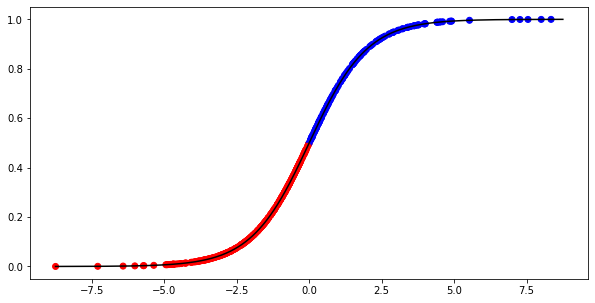

In [128]:
plot_psychometric_function(np.mean(idata.posterior.logits, axis=1)[-1])